In [40]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

import pandas as pd

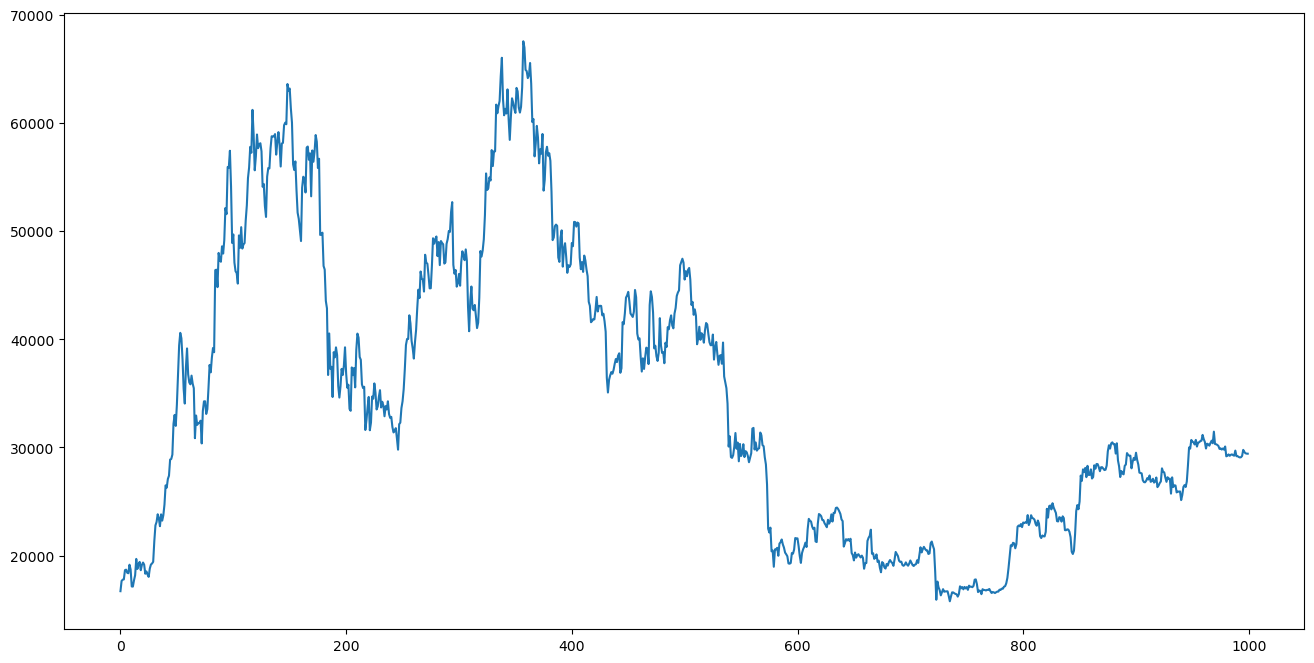

In [41]:
import ccxt
binance = ccxt.binance()
symbol = 'BTC/USDT'

ohlcv = binance.fetch_ohlcv(symbol, '1d', limit=1000)
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


plt.figure(figsize=(16,8))
plt.plot(df["close"],label='close Price history')

In [42]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['timestamp','close'])

for i in range(0,len(data)):
    new_dataset["timestamp"][i]=data['timestamp'][i]
    new_dataset["close"][i]=data["close"][i]

new_dataset.index=new_dataset.timestamp
new_dataset.drop("timestamp",axis=1,inplace=True)

In [43]:
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

In [44]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(x_train_data, y_train_data)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
predicted_closing_price=model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price.reshape(-1, 1))


In [46]:
model_filename = "../models/xgboost_model.json"
model.save_model(model_filename)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9080\2356543652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


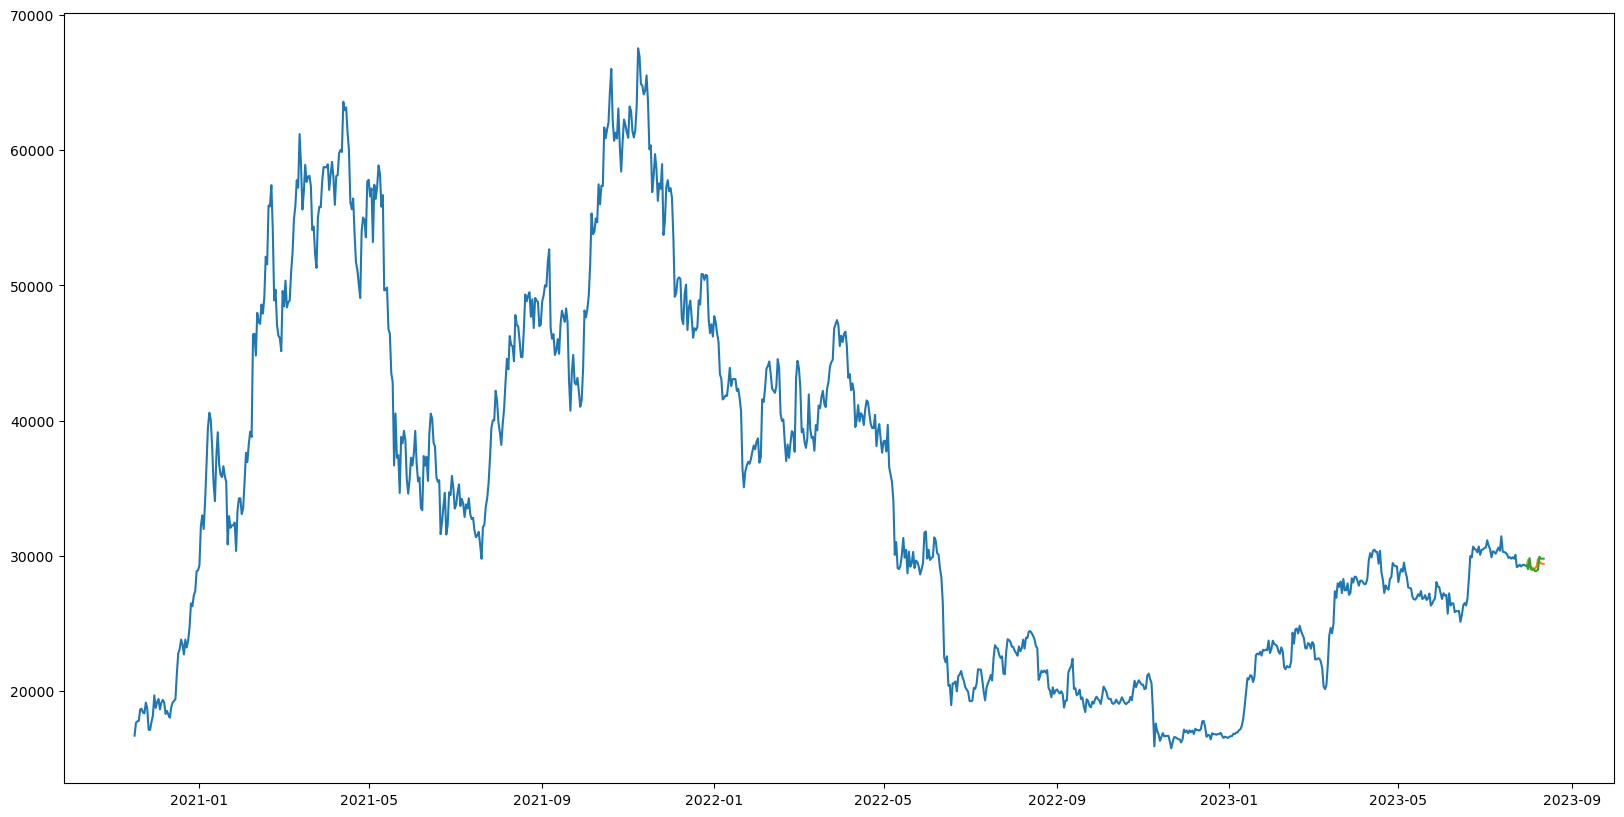

In [47]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["close"])
plt.plot(valid_data[['close',"Predictions"]])